In [1]:
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
import sklearn
from sklearn import cluster

In [2]:
def flatten(pool):
    res = []
    for v in pool:
        if isinstance(v, list):
            res += flatten(v)
        else:
            res.append(v)
    return res 

# Data exploration

I start by looking at the data. How many entries,
how many topics, how many words repeats between the topics, 
how many topics has each post.

In [3]:
data = pd.read_json('posts_with_topics.json')

In [4]:
print('numer of posts:',len(data))
data[:3]

numer of posts: 347


,postId,topics
0,2.190123e+30,"[Politics, International relations, Donald Tru..."
1,2.190123e+30,"[Politics, Donald Trump, Political career of D..."
2,2.190123e+30,"[Politics, Donald Trump, Political career of D..."


In [5]:
# topic occurrences counter

z=flatten(list(data['topics']))
df_occurrences=pd.DataFrame(Counter(z),index=['Occ']).T.sort_values('Occ',ascending=False)

# Map topic to occurences 
# Needed to choose the font size of the topics
occ_map=dict(zip(list(df_occurrences.index),list(df_occurrences.Occ)))

df_occurrences.head()

,Occ
Politics,150
Government,116
International relations,76
Conflicts,67
Donald Trump,59


In [6]:
# word occurrences couter

topics=list(set(flatten(list(data['topics']))))
topics_split=[re.sub('[\(\)1-9-]','',a).lower().replace('of','').replace('and','').replace('the','').split() for a in topics]

z=Counter(flatten(topics_split))
df_occurence_kw=pd.DataFrame(Counter(z),index=['Occ']).T.sort_values('Occ',ascending=False)

df_occurence_kw.head()

,Occ
politics,9
relations,8
government,7
korea,7
sports,5


In [7]:
# counter of topics per single post

# the data shows that many posts have a single topic (~40), 
# making the cross selection harder

len_topics=pd.DataFrame(Counter([len(data.loc[i,'topics']) for i in range(len(data))]),
             index=['Topics per Post Counter']).T.sort_values('Topics per Post Counter',ascending=False).head()
len_topics.head()

,Topics per Post Counter
5,76
1,40
3,37
4,36
2,31


In [8]:
#Mapping betweent topics and categorical index

cat_map=dict(zip(list(range(len(topics))),topics))
print('number of topics:',len(cat_map))

number of topics: 110


# Defining a distance between topics

In order to slip the word cloud into different topics, we need to define what we mean by "different".
In practice we need to define a distance between topics. Here I attempt 3 possible methods.

1 - Computing eucledead distance between vectors, built by factorization of the occurence sparse-matrix 

2 - Distance by topic appearing in the same post (shallow relationship) 

3 - The above, plus distance defined by common words in the Topic title

Additional notes 

Distances will either use a euclidian method, that can be used for Ward linkage, or a non-euclidea method that will restrict us to Single, Complete, and average linkage.




# Factorization of Occurence sparse-matrix

INPUT: Here we need to choose the factorization dimention.
This will provide the dimension of the feature vectors, needed to compute distances between topics.
It is sensible to choose for a number of features similar to the maximal amount of word-clouds.

In [9]:
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [10]:
# Built the occurence sparse-matrix

test_matrix=pd.DataFrame()

for i in range(len(topics)):
    temp_list=[]
    for j in range(len(data)):
        if topics[i] in data.topics[j]:
            temp_list.append(1)
        else:
            temp_list.append(0)
    test_matrix[topics[i]]=temp_list
test_matrix=test_matrix

In [11]:
# Factorization
#--------------------------

NUMBER_OF_FACTORS_MF = 50

#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix = csc_matrix(test_matrix.values, dtype=float)
users_ids = list(data.postId)

#The number of factors to factor the user-item matrix.

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = topics, index=users_ids).transpose()
cf_preds_df.head(10)

distance_rec=np.zeros((len(topics),len(topics)))

for i in range(len(topics)):
    for j in range(i):  
        distance_rec[i,j]=np.linalg.norm(Vt.T[i]-Vt.T[j])

distance_rec=distance_rec+distance_rec.T #simmetrization 
#distance_rec=distance_rec/np.amax(distance_rec)

## Visualize distribution

We can visualize the distribution of the distances in out data-set. These are normalized distances between 0 and 1. For succesful clustering, we would expect these distances to be clearly distributed over the whole interval.

In [12]:
from matplotlib import pyplot as plt

min distance: 0.0
max distance: 0.51


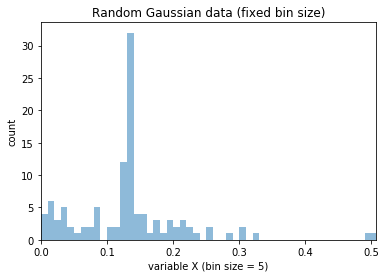

min distance: 0.0
max distance: 0.57


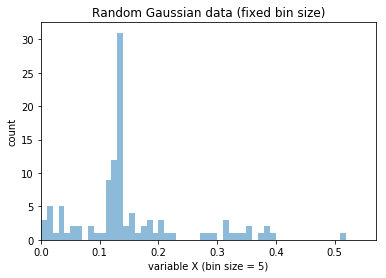

min distance: 0.0
max distance: 0.59


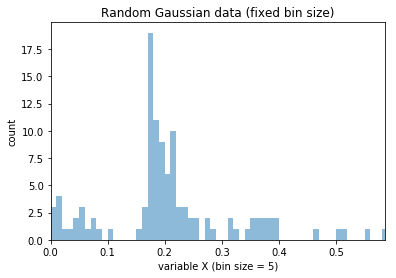

In [13]:
for n in range(2,5):
    NUMBER_OF_FACTORS_MF = n

    #Creating a sparse pivot table with users in rows and items in columns
    users_items_pivot_matrix = csc_matrix(test_matrix.values, dtype=float)
    users_ids = list(data.postId)

    #The number of factors to factor the user-item matrix.

    #Performs matrix factorization of the original user item matrix
    U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

    #Converting the reconstructed matrix back to a Pandas dataframe
    cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = topics, index=users_ids).transpose()
    cf_preds_df.head(10)

    distance_rec=np.zeros((len(topics),len(topics)))

    for i in range(len(topics)):
        for j in range(i):  
            distance_rec[i,j]=np.linalg.norm(Vt.T[i]-Vt.T[j])

    distance_rec=distance_rec+distance_rec.T #simmetrization 
    #distance_rec=distance_rec/np.amax(distance_rec)

    distribution_list=(distance_rec).tolist()[0]

    data_hist = distribution_list

    # fixed bin size
    bins = np.arange(0, 1, 0.01) # fixed bin size

    print('min distance:',min(data_hist))
    print('max distance:', round(max(data_hist),2))
    plt.xlim([min(data_hist), max(data_hist)])

    plt.hist(data_hist, bins=bins, alpha=0.5)
    plt.title('Random Gaussian data (fixed bin size)')
    plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')

    plt.show()

# Standard Occurence Distance

Here we compute the distance matrix by common appearance of the topics.
This distance is a shallow distance, as it does not consider transitivity.
So if {'Topic A','Topic B'} and {'Topic B','Topic C'} are present in the data set, 
then 'Topic A' and 'Topic C' are not considered near. This could be improved at the cost of computation time needed to go trough all the possible "linked" occurrences. Here I only tested the shallow form of this distance.

In [14]:
# distance matrix by topics appearing in the same post

distance=np.zeros((len(topics),len(topics)))

for i in range(len(topics)):
    for j in range(i):  
        common=len(data[(data['topics'].apply(lambda x: topics[i] in x))&(data['topics'].apply(lambda x: topics[j] in x))])
        distance[i,j]=1-common/max(df_occurrences.loc[topics[i],'Occ'],df_occurrences.loc[topics[j],'Occ'])

distance=distance+distance.T #simmetrization 

Additionaly, we consider the distance between topics that contain the same words (for example: "Donald Trump" and "Donald Trump Family"). This distance can be added to the above for stronger clustering of topics that are clearly related. This method does not consider stemming of similar words (for example "War" and "Warfare") and could be inproved by it.

In [15]:
# distance matrix by shared common words between topics

distance_2=np.zeros((len(topics),len(topics)))

for i in range(len(topics_split)):
    for j in range(i):
        for ele in (topics_split[i]):
            if ele in topics_split[j]:
                distance_2[i,j]+=1
                
distance_2=distance_2+distance_2.T #simmetrization
distance_2=distance_2/np.amax(distance_2) #normalization

In [16]:
distance_fin=distance-distance_2 # additive distance constidering both methods
distance_fin[distance_fin < 0] = 0 # Make sure distances are always positive definite

## Visualize distance matrices
Darker spots have lower distances

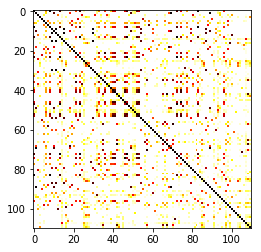

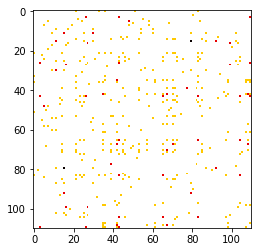

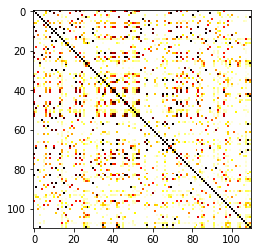

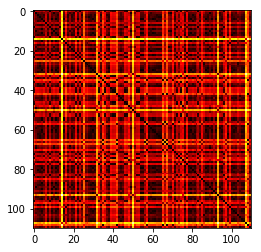

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(distance, cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(-distance_2, cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(distance_fin, cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(distance_rec/np.max(distance_rec), cmap='hot', interpolation='nearest')
plt.show()

# Clustering

Using the distances defined above we can now cluster the topics. The software we are interested in building has a hierarchical structure and the number of clusters is not defined. For such case I decided to use AgglomerativeClustering, an algorithm botton-up that compare distances of topic from the leaf of a tree and aggregate nearest topics. This builds a tree stucture that can be used to have a variable number of clusters depending on the depth of the node we look at. The method is not as fast as K-means (top-bottom). Nevetheless, we do not have to compute the clustering for each number of splits. We are going to build a dataframe that can be then stored and can be read efficently. So even if building/updating the tree is not time-efficient, response time will be short.

Additional notes:
    
For large sumple sets, we should use K-means with complexity O(K*N^2Log_K(N))
Aggregation has complexity O(N^3)

We could use two methods to reduce complexity of Aggregations:
### - Add connectivity restrictions (reduce one N into K, for example KNN)
### - Start contrusting the tree from a smaller set of Samples 

For the second we could use a K-Mean clustering or other clustering method for a fine clustering and then use the clusters as reppresentatives (either usind centroid, or most common entry). This way we will reduce N to a smaller size.



## Silhouette Coefficient

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

s=(b-a)/max(b,a)

- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks: 
The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [18]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans

Standard=[]
Composed_Single=[]
Composed_Complete=[]
Composed_Average=[]
Factorization=[]
    
    
for en in range(2,30):
    num_clusters=en

    #-------------- Using only distance by common posts

    cluster_str=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                           linkage='complete')
    cluster_str.fit(distance)
    temp=pd.DataFrame(dict(zip(topics,cluster_str.labels_)),index=['Cluster_standard']).T

    #-------------- Using combined distance (common posts+common words)
    cluster_com_com=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                           linkage='complete')
    cluster_com_com.fit(distance_fin)
    #temp_2=pd.DataFrame(dict(zip(topics,cluster_com.labels_)),index=['Cluster_combined']).T
     
    #-------------- Using combined distance (common posts+common words)
    cluster_com_sing=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                           linkage='single')
    cluster_com_sing.fit(distance_fin)
    #temp_2=pd.DataFrame(dict(zip(topics,cluster_com.labels_)),index=['Cluster_combined']).T
     
    #-------------- Using combined distance (common posts+common words)
    cluster_com_avg=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                           linkage='average')
    cluster_com_avg.fit(distance_fin)
    temp_2=pd.DataFrame(dict(zip(topics,cluster_com_avg.labels_)),index=['Cluster_combined']).T


    #-------------- Using factorization distance 
    cluster_rec=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean',
                                           linkage='ward')
    cluster_rec.fit(Vt.T)#distance_rec
    temp_3=pd.DataFrame(dict(zip(topics,cluster_rec.labels_)),index=['Cluster_Rec']).T

    labels = cluster_rec.labels_
    
    #print(en,'--------')
    #print('Standard')
    Standard.append(metrics.silhouette_score(distance, cluster_str.labels_,metric="precomputed"))
    #print(metrics.silhouette_score(distance, cluster_str.labels_,metric="precomputed"))
    #print('Composed Single')
    Composed_Single.append(metrics.silhouette_score(distance_fin, cluster_com_sing.labels_,metric="precomputed"))
    #print(metrics.silhouette_score(distance_fin, cluster_com_sing.labels_,metric="precomputed"))
    #print('Composed Complete')
    Composed_Complete.append(metrics.silhouette_score(distance_fin, cluster_com_com.labels_,metric="precomputed"))
    #print(metrics.silhouette_score(distance_fin, cluster_com_com.labels_,metric="precomputed"))
    #print('Composed Average')
    Composed_Average.append(metrics.silhouette_score(distance_fin, cluster_com_avg.labels_,metric="precomputed"))
    #print(metrics.silhouette_score(distance_fin, cluster_com_avg.labels_,metric="precomputed"))
    #print('Factorization')
    Factorization.append(metrics.silhouette_score(distance_rec, cluster_rec.labels_,metric="precomputed"))
    #print(metrics.silhouette_score(distance_rec, cluster_rec.labels_,metric="precomputed"))

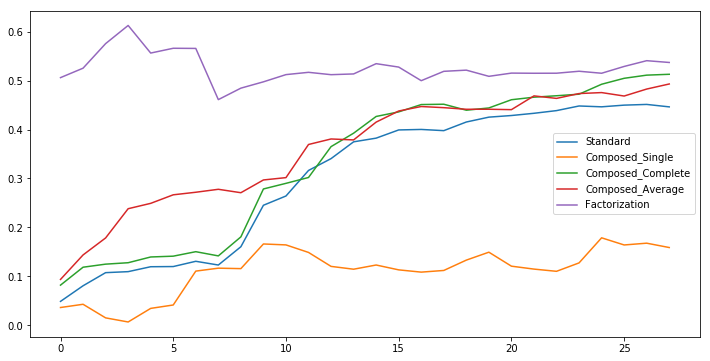

In [19]:
pd.DataFrame({'Standard':Standard,'Composed_Single':Composed_Single,
              'Composed_Complete':Composed_Complete,'Composed_Average':Composed_Average,
              'Factorization':Factorization}).plot(figsize=(12,6))

In [20]:
#-------------- Build DataFrame to compare classes
final=pd.merge(df_occurrences, temp, left_index=True, right_index=True)
final=pd.merge(final, temp_2, left_index=True, right_index=True)
final=pd.merge(final, temp_3, left_index=True, right_index=True)

In [21]:
# define number of clusters - only needed to compare methods. 
# The clustering procedure actually provide us with a tree structure 
# independent of number of clusters

num_clusters=2

#-------------- Using only distance by common posts

cluster_str=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                       linkage='average')
cluster_str.fit(distance)
temp=pd.DataFrame(dict(zip(topics,cluster_str.labels_)),index=['Cluster_standard']).T

#-------------- Using combined distance (common posts+common words)
cluster_com=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed',
                                       linkage='complete')
cluster_com.fit(distance_fin)
temp_2=pd.DataFrame(dict(zip(topics,cluster_com.labels_)),index=['Cluster_combined']).T

#-------------- Using factorization distance 
cluster_rec=sklearn.cluster.AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean',
                                       linkage='ward')
cluster_rec.fit(Vt.T)#distance_rec
temp_3=pd.DataFrame(dict(zip(topics,cluster_rec.labels_)),index=['Cluster_Rec']).T

# K means

In [22]:
from sklearn.cluster import KMeans
import numpy as np

In [23]:
levels=[]
kmeans = KMeans(n_clusters=2, random_state=0).fit(Vt.T)
labels_km=kmeans.labels_
levels.append(labels_km)
temp_R=[]
temp_L=[]
for i in range(len(Vt.T)):
    if labels_km[i]:
        temp_R.append(Vt.T[i])
    else:
        temp_L.append(Vt.T[i])
kmeans_R = KMeans(n_clusters=2, random_state=0).fit(temp_R)
kmeans_L = KMeans(n_clusters=2, random_state=0).fit(temp_L)

In [24]:
kmeans_Right_label=list(kmeans_R.labels_)

In [25]:
kmeans_Left_label=list(kmeans_L.labels_+2)

In [26]:
print('K-means 2 levels')
print(metrics.silhouette_score(Vt.T,labels_km))
print('K-means 4 levels')
print(metrics.silhouette_score(temp_R+temp_L,kmeans_Right_label+kmeans_Left_label))

K-means 2 levels
0.4562763711650913
K-means 4 levels
0.5369717487322314


## Calinski-Harabaz Index

- Needs Eucledean distance
- Ratio of the between-clusters dispersion mean and the within-cluster dispersion

In [27]:
from sklearn import metrics

In [28]:
print('Higher is better')
print('---------------')

print('Factorization {} levels'.format(num_clusters))
print(metrics.calinski_harabaz_score(Vt.T, cluster_rec.labels_))
print('K-means 2 levels')
print(metrics.calinski_harabaz_score(Vt.T,labels_km))
print('K-means 4 levels')
print(metrics.calinski_harabaz_score(temp_R+temp_L,kmeans_Right_label+kmeans_Left_label))

Higher is better
---------------
Factorization 2 levels
33.72868206252934
K-means 2 levels
34.17404021376078
K-means 4 levels
41.4903040470964


## Davies Bouldin Score

- Needs Eucledean distance
- The index is defined as the average similarity between each cluster 

In [29]:
print('Lower is better')
print('---------------')

print('Factorization {} levels'.format(num_clusters))
print(metrics.davies_bouldin_score(Vt.T, cluster_rec.labels_))
print('K-means 2 levels')
print(metrics.davies_bouldin_score(Vt.T,labels_km))
print('K-means 4 levels')
print(metrics.davies_bouldin_score(temp_R+temp_L,kmeans_Right_label+kmeans_Left_label))

Lower is better
---------------
Factorization 2 levels
0.6944943834579851
K-means 2 levels
0.9542677423919383
K-means 4 levels
0.5048638139530034


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [30]:
class_km=pd.DataFrame(dict(zip(list(final.index),labels_km)),index=[0]).T
class_km[class_km==1].dropna()

,0
Politics,1.0
Warfare,1.0
Foreign policy,1.0
Government of North Korea,1.0
Presidency of Donald Trump,1.0
Later lives,1.0
Diplomacy,1.0
Government of Korea,1.0
Israel,1.0
Crimes,1.0


## Compare Clustering

Here we can compare clusters created with different distances. Some clear topics like sport and politics are well separated. Some more subtile differences like International Politics are handled differently by each metric choice.

In [31]:
final[final['Cluster_Rec']==1]

,Occ,Cluster_standard,Cluster_combined,Cluster_Rec
Public sphere,32,1,18,1
Justice,26,10,2,1
Law,26,10,2,1


In [32]:
final[final['Cluster_combined']==1]

,Occ,Cluster_standard,Cluster_combined,Cluster_Rec
Donald Trump,59,0,1,10
Political career of Donald Trump,52,0,1,10
Presidency of Donald Trump,28,0,1,7
Later lives,26,0,1,7
Trump family,25,0,1,7
American anti–illegal immigration activists,12,0,1,24


In [33]:
final[final['Cluster_standard']==1]

,Occ,Cluster_standard,Cluster_combined,Cluster_Rec
Public sphere,32,1,18,1
Human activities,27,1,23,0


## Visualize Tree
Here I used a small script to plot the tree structure and consider the differences between the 3 different methods.

In [34]:
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================
This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

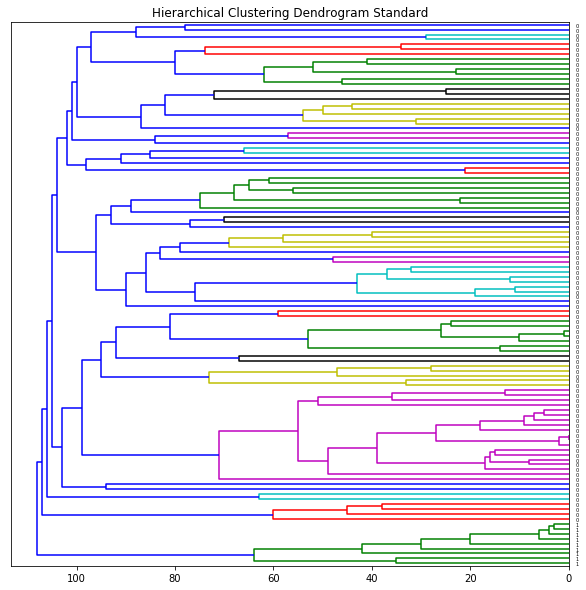

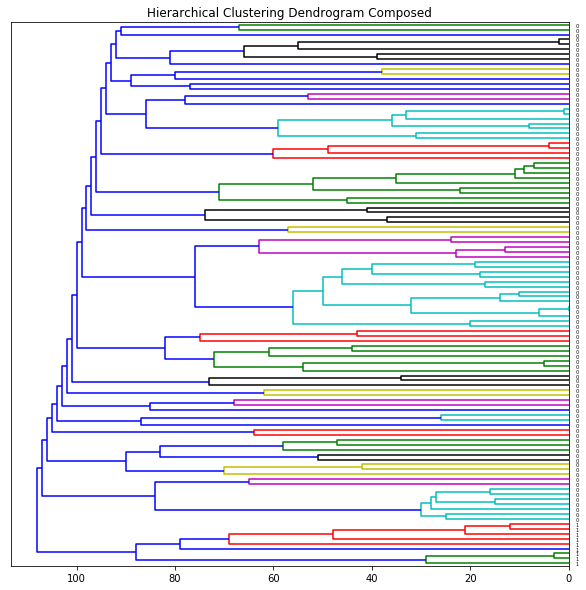

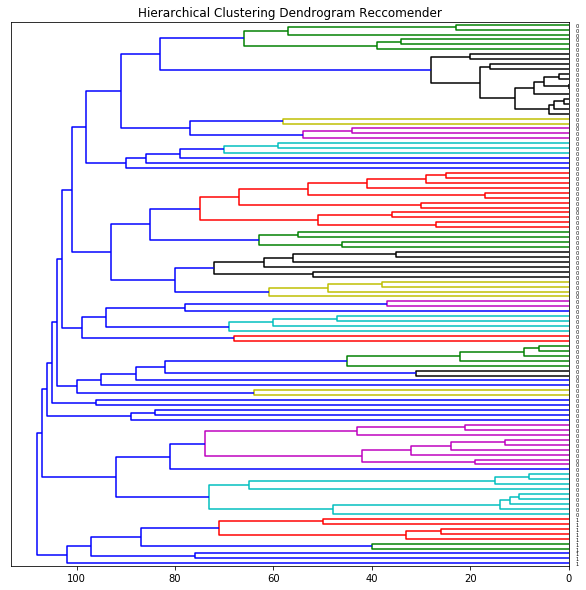

In [35]:
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram Standard')
fig=plot_dendrogram(cluster_str, labels=cluster_str.labels_,orientation='left')
plt.show()

plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram Composed')
fig=plot_dendrogram(cluster_com, labels=cluster_com.labels_,orientation='left')
plt.show()

plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram Reccomender')
fig=plot_dendrogram(cluster_rec, labels=cluster_rec.labels_,orientation='left')
plt.show()

# Getting Tree into DataFrame and Json

I choose to consider the factorization method, as it can be optimized by choosingthe number of features and may pick up more subtle similarities between topics.

In [36]:
cluster_final=cluster_rec

In order to build the tructure tree, I will get from the cluster the children of each node, that defines completly the structure of the tree. The output of the sklearn clustering is a bit involved but the output is explained in their documentation as follow:

"children_ : array-like, shape (n_samples-1, 2)
The children of each non-leaf node. Values less than n_samples correspond 
to leaves of the tree which are the original samples.
A node i greater than or equal to n_samples is a non-leaf node 
and has children children_[i - n_samples]. 
Alternatively at the i-th iteration, children[i][0] and children[i][1] 
are merged to form node n_samples + i"

The following cells are not reader-friendly but the final result is a clear database that can be saved as a json file.

In [37]:
children=cluster_final.children_

children_df=pd.DataFrame(data=children,index=range(len(children)), columns=['C1','C2'])

In [38]:
temp=[]
for i in range(cluster_final.n_leaves_,np.amax(children)+1):
    temp.append([i,cluster_final.children_[i - cluster_final.n_leaves_][0],
                cluster_final.children_[i - cluster_final.n_leaves_][1]])

In [39]:
# Define node IDs column
nodes_df=pd.DataFrame(data=temp,index=range(len(temp)),columns=['node_id','C1_','C2_'])
tot_df=pd.concat([nodes_df,children_df],axis=1).fillna(-1)[['node_id','C1','C2']]
tot_df['node_id']=tot_df['node_id'].apply(int)

In [40]:
# Define parents ID column
parent=[]
for i in range(len(tot_df)):
    for j in range(len(tot_df)):
        if tot_df.loc[i,'node_id'] in [tot_df.loc[j,'C1'],tot_df.loc[j,'C2']]:
            parent.append(j)
    if len(parent)==i:
        parent.append(-1)

tot_df['Parent_id']=parent # not needed after all

In [41]:
# Mapping Categoricals 
df_alternative=tot_df.copy()
df_alternative['C1']=df_alternative['C1'].replace(cat_map)
df_alternative['C2']=df_alternative['C2'].replace(cat_map)

In [42]:
# Adding Occurences to each topic to be displayed with the correct font size
df_alternative['C1'].replace(cat_map)

try_list=[]
for i in range(len(df_alternative)):
    if type(df_alternative.loc[i,'C1'])==str:
        word=(df_alternative.loc[i,'C1'])
        count=(occ_map[df_alternative.loc[i,'C1']])
        try_list.append([word, count])
    else:
        try_list.append(df_alternative.loc[i,'C1'])
df_alternative['C1']=try_list

try_list=[]
for i in range(len(df_alternative)):
    if type(df_alternative.loc[i,'C2'])==str:
        word=(df_alternative.loc[i,'C2'])
        count=(occ_map[df_alternative.loc[i,'C2']])
        try_list.append([word, count])
    else:
        try_list.append(df_alternative.loc[i,'C2'])
df_alternative['C2']=try_list

In [43]:
temp=tot_df[tot_df['node_id']==-1][['node_id','C1','C2']] # add root node ID/Parent as -1

In [44]:
df_alternative=df_alternative.drop('Parent_id',axis=1).rename(columns={'C1':'Child_1','C2':'Child_2'})

## Save Json

We finally can save our tree structure into a json file. This will be a dataframe with the following columns: 

node_ID, Child_1, Child_2.


The Child_1, Child_2 entries can either be an index of a children node or, in the case of a leaf, a list in the form ["Topic","Size"]. In this way it will be fast for each node to get all the leaves associated with it.

In [45]:
# Save to json with filename

filename='compact_df.json'

with open(filename, 'w') as f:
    f.write(df_alternative.to_json(orient='records', lines=True))

In [46]:
# Here I test reading the json to make sure parsing works correctly
pd.read_json('compact_df.json', lines=True).head()

,Child_1,Child_2,node_id
0,"[International sports competitions, 8]","[Team sports, 8]",110
1,"[Association football competitions, 11]","[FIFA competitions, 9]",111
2,[International association football competitio...,"[Sports competitions, 8]",112
3,"[Sports, 15]",111,113
4,"[Sports events, 8]",113,114


# Usage

In the provided solution you will find the following files:

compact_df.json - the stored dataframe from the above study

Cluster.py - a class script to build a tree from a dataframe and navigate trought it.

Words_Cloud_Splitter.ipynb - a user-friendly notebook to load the data and navigate the tree.


# Problems and possible Improvements

The above is a first prototype that can be a used as a benkmark. Next, we would improve both the clustering and the storing procedure.

To make sure the algorithm is correct I compared the largest clusters between different methods. Results appear to be reasonable with a small margin of miss-clustering.

I noticed, for instance, that the clustering (the tree-structure) is quite unbalanced. This is caused by the small dataset at hand, where political topics are more frequent. The aggregation procedure and the distance measure could be modified in order to provide a more balanced tree.

For production, the database could be build with faster methods like K-means, scaling better for large datasets. Nonetheless, fast computation time for the clustering is not the main goal of this software. The most important factor would be reading time. The tree structure provided is a very efficient method to store clusters.

Additional Notes:
To check consistencies we can use Adjusted Rand index to compare various models or to test again human labelling of a randomly selected test-set.

Adjusted Rand index:
- Symmetric
- Permutation independent
- Label name independent



# Parameters
 
- Metric/Distance/Vecotors
- hyper-parameters: Factorization dimention
- Method (K-means/Agglomerate)

if Agglomerate:
- Connectivity matrix (faster)
- Linkage type


How to compare models:

- Silhouette Coefficient
- Indexes/scores (only Eucledean)
- Human labelling